# Отток клиентов банка

Необходимо спрогнозировать отток клиентов банка.

В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком.

Пострим модель с предельно большим значением *F1*-меры.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой и другими метриками.


## Подготовка данных

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
pd.options.mode.chained_assignment = None
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score 
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df = pd.read_csv('datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Обращаем внимание, что имеются пропуски в поле Tenure

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Сразу удалим бесполезные в нашем исследовании столбцы (RowNumber, CustomerId), это просто ключи, никак не характеризующие объект исследования.

In [5]:
df = df.drop('RowNumber', axis=1)

In [6]:
df = df.drop('CustomerId', axis=1)

In [7]:
df = df.drop('Surname', axis=1)

In [8]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В таблице есть булевы признаки, но имеющие целочисленным тип данных. Приведём их к логичекскому. Сначала убедимся, что там только нули и единицы

In [9]:
df[['HasCrCard', 'IsActiveMember', 'Exited']].describe()

,HasCrCard,IsActiveMember,Exited
count,10000.00000,10000.000000,10000.000000
mean,0.70550,0.515100,0.203700
std,0.45584,0.499797,0.402769
min,0.00000,0.000000,0.000000
25%,0.00000,0.000000,0.000000
50%,1.00000,1.000000,0.000000
75%,1.00000,1.000000,0.000000
max,1.00000,1.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Проверим содержимое других столбцов

In [11]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [12]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [13]:
df[['Age', 'Tenure', 'NumOfProducts', 'Balance', 'EstimatedSalary']].describe()

,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
count,10000.000000,9091.000000,10000.000000,10000.000000,10000.000000
mean,38.921800,4.997690,1.530200,76485.889288,100090.239881
std,10.487806,2.894723,0.581654,62397.405202,57510.492818
min,18.000000,0.000000,1.000000,0.000000,11.580000
25%,32.000000,2.000000,1.000000,0.000000,51002.110000
50%,37.000000,5.000000,1.000000,97198.540000,100193.915000
75%,44.000000,7.000000,2.000000,127644.240000,149388.247500
max,92.000000,10.000000,4.000000,250898.090000,199992.480000


<AxesSubplot:>

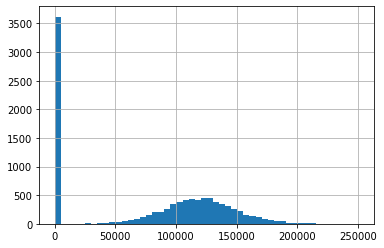

In [14]:
df['Balance'].hist(bins=50)

Характерный и объяснимый выброс с нулевым балансом. Не все держат деньги в банке, многие пользуются лишь кредитами.

<AxesSubplot:>

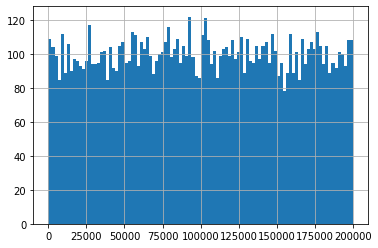

In [15]:
df['EstimatedSalary'].hist(bins=100)

<AxesSubplot:>

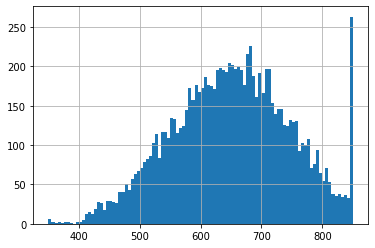

In [16]:
df['CreditScore'].hist(bins=100)

In [17]:
df[df['CreditScore']==850]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
38,850,France,Male,36,7.0,0.00,1,1,1,40812.90,0
180,850,Spain,Female,45,NaN,122311.21,1,1,1,19482.50,0
200,850,Spain,Male,30,2.0,141040.01,1,1,1,5978.20,0
223,850,France,Male,33,10.0,0.00,1,1,0,4861.72,1
...,...,...,...,...,...,...,...,...,...,...,...
9581,850,France,Female,28,9.0,0.00,2,1,1,164864.67,0
9646,850,Spain,Male,71,10.0,69608.14,1,1,0,97893.40,1
9688,850,France,Male,68,5.0,169445.40,1,1,1,186335.07,0
9931,850,France,Female,34,NaN,101266.51,1,1,0,33501.98,0


Выброс на 850. Возможно, максимальный рейтинг присваивается какой-то категории клиентов в ручном режиме, либо как стартовый новым клиентам. Стоит уточнить у специалистов, аномалия это или нет.

Других особенностей в данных не замечено.

**Целевой признак - Exited**

Преобразуем категориальные признаки в численные

### Пропуски

<AxesSubplot:>

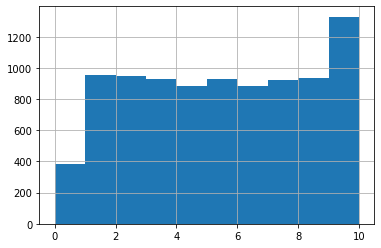

In [18]:
df['Tenure'].hist(bins=10)

In [19]:
df[df['Tenure'].isnull()==True]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [20]:
df[(df['Tenure'].isnull()==True)].mean()

CreditScore          648.451045
Age                   38.647965
Tenure                      NaN
Balance            76117.341474
NumOfProducts          1.530253
HasCrCard              0.710671
IsActiveMember         0.510451
EstimatedSalary    99180.389373
Exited                 0.201320
dtype: float64

In [21]:
df.groupby('Tenure').mean()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Tenure,,,,,,,,
0.0,651.913613,39.306283,80135.307277,1.437173,0.651832,0.531414,99565.395157,0.235602
1.0,648.681723,39.646008,77365.221712,1.494748,0.670168,0.551471,100635.368718,0.223739
2.0,654.644211,39.246316,76502.413053,1.584211,0.706316,0.540000,99120.730168,0.194737
3.0,651.096983,38.984914,78105.560356,1.535560,0.713362,0.517241,97351.648168,0.213362
4.0,650.681356,38.116384,74133.600373,1.519774,0.710734,0.509605,100041.330836,0.207910
5.0,649.962244,39.242718,76138.007217,1.564186,0.700108,0.509169,101239.472233,0.201726
6.0,647.757094,38.637911,74970.085698,1.515323,0.715096,0.510783,100151.566924,0.200908
7.0,649.195676,38.349189,75915.378086,1.525405,0.708108,0.513514,101842.455362,0.172973
8.0,648.618435,38.496249,77994.797685,1.530547,0.734191,0.504823,100611.163290,0.186495


При беглом анализе средние для пустого Tenure похожи на средние для Tenure 4 или 6. Во всяком случае исключён вариант, что это какая-то группа с характерными данными в других полях, это не заметно. 
Чтобы не искажать распределение значений Tenure, заполним пропуски случайными значениями.

In [22]:
df['Tenure'] = df['Tenure'].apply(lambda x: np.random.choice(df['Tenure'].dropna().values) if (np.isnan(x)) else x)

<AxesSubplot:>

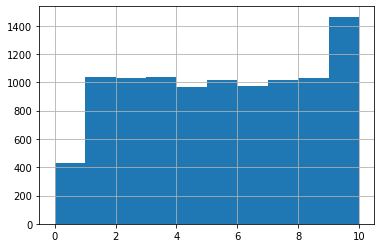

In [23]:
df['Tenure'].hist(bins=10)

Характер распределения не изменился, это для нас важно.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### One-Hot Encoding категориальных признаков

Категориальные признаки:
    1. Geography
    2. Gender

In [25]:
df.shape

(10000, 11)

In [26]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [27]:
df_ohe.shape

(10000, 12)

In [28]:
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Разделение данных для тренировки, валидации и тестирования

Отделим целевой признак. Выделим 60% всех данных как тренировочные, а оставшуюся часть разделим на валидационную и тестовую.

In [29]:
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=42)

In [31]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=42)

In [32]:
features_train.shape, target_train.shape

((6000, 11), (6000,))

In [33]:
features_valid.shape, target_valid.shape

((2000, 11), (2000,))

In [34]:
features_test.shape, target_test.shape

((2000, 11), (2000,))

### Масштабирование признаков

In [35]:
features_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [36]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [37]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [38]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9761,1.603068,2.027653,-0.677175,-0.048229,0.824078,1,1,-1.452982,1,0,0
3159,1.883194,-1.520072,-0.331795,0.884122,-0.905967,1,0,-1.403696,0,0,1
1489,-0.451185,0.014079,1.049725,1.050751,-0.905967,0,1,1.290549,0,0,0
2987,0.243941,-1.232419,-1.367935,0.517839,-0.905967,0,0,-0.709924,1,0,0
812,-1.416062,-0.561228,-0.677175,-1.214721,0.824078,1,1,-0.736719,0,1,0


## Исследование задачи

Сделаем функцию для подсчёта характеристик модели

In [39]:
def get_model_scores(model, features_valid, target_valid):
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    accuracy = accuracy_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid, labels=np.unique(predicted_valid))
    precision = precision_score(target_valid, predicted_valid, labels=np.unique(predicted_valid))
    f1 = f1_score(target_valid, predicted_valid, labels=np.unique(predicted_valid))
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    return accuracy, recall, precision, f1, auc_roc  

### LogisticRegression

In [40]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [41]:
matrix = confusion_matrix(target_valid, predicted_valid)
matrix

array([[1505,   65],
       [ 337,   93]], dtype=int64)

In [42]:
matrix[0].sum(), matrix[1].sum()

(1570, 430)

In [43]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.799,0.216279,0.588608,0.316327,0.779153


<AxesSubplot:xlabel='fpr'>

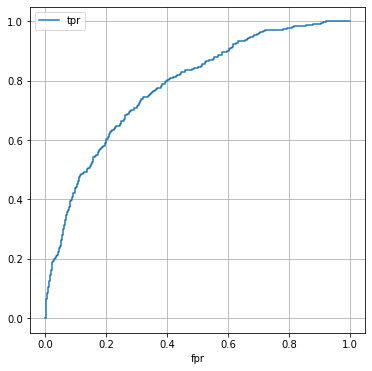

In [44]:
fpr, tpr, threshold = roc_curve(target_valid, probabilities_one_valid)
pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':threshold}).plot(x='fpr', y='tpr', grid=True, figsize=(6,6))

Наша характеристика f1 (0.32) весьма далека от желаемого значения (0.59) при базовых параметрах модели. 

### DecisionTreeClassifier

In [45]:
model = DecisionTreeClassifier(random_state=42)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [46]:
matrix = confusion_matrix(target_valid, predicted_valid)
matrix

array([[1360,  210],
       [ 210,  220]], dtype=int64)

In [47]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.79,0.511628,0.511628,0.511628,0.688935


<AxesSubplot:xlabel='fpr'>

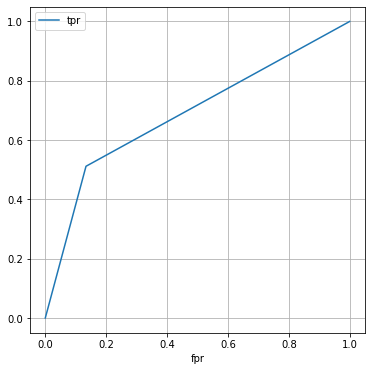

In [48]:
fpr, tpr, threshold = roc_curve(target_valid, probabilities_one_valid)
pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':threshold}).plot(x='fpr', y='tpr', grid=True, figsize=(6,6))

Для этой модели сходу результат получше (f1=0.52)

### RandomForestClassifier

In [49]:
model = RandomForestClassifier(random_state=42)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [50]:
matrix = confusion_matrix(target_valid, predicted_valid)
matrix

array([[1512,   58],
       [ 223,  207]], dtype=int64)

In [51]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.8595,0.481395,0.781132,0.595683,0.862186


Результаты RandomForestClassifier пока лучше всех по всем параметрам, кроме полноты.

### CatBoostClassifier

In [52]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(random_state=42, verbose=25, iterations=100)
model.fit(features_train, target_train)

Learning rate set to 0.182896
0:	learn: 0.6058734	total: 156ms	remaining: 15.4s
25:	learn: 0.3275662	total: 217ms	remaining: 617ms
50:	learn: 0.3083655	total: 281ms	remaining: 270ms
75:	learn: 0.2944701	total: 337ms	remaining: 106ms
99:	learn: 0.2846562	total: 389ms	remaining: 0us


In [53]:
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [54]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.861,0.483721,0.787879,0.599424,0.867611


<AxesSubplot:xlabel='fpr'>

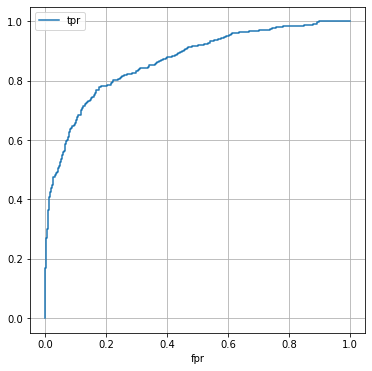

In [55]:
fpr, tpr, threshold = roc_curve(target_valid, probabilities_one_valid)
pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':threshold}).plot(x='fpr', y='tpr', grid=True, figsize=(6,6))

### Вывод

Классы не сбалансированы. Соотношение положительного и отрицательного класса приблизительно 1:4, Доля ошибок в положительном классе велика во всех рассмотренных моделях с базовыми гиперпараметрами.

Модель **CatBoostClassifier** с базовыми гиперпараметрами уже удовлетворяет заданным требованиям (f1 >= 0.59).

## Борьба с дисбалансом

### Сбалансированные классы

Придадим объектам редкого класса больший вес.

#### LogisticRegression

In [56]:
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [57]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.7005,0.709302,0.391528,0.504549,0.783582


Для модели **LogisticRegression** прирост в оценке f1 значительный c 0.32 до 0.50

#### DecisionTreeClassifier

In [58]:
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [59]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.7855,0.493023,0.501182,0.497069,0.679314


Для модели **DecisionTreeClassifier** оценка f1 пошла вниз с 0.52 до 0.50

#### RandomForestClassifier

In [60]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [61]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.8575,0.448837,0.80083,0.575261,0.861617


Модель требует более тонкой настройки. Балансировка классов ухудшила показатели.

### Увеличение выборки

In [62]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

#### LogisticRegression

In [63]:
scores = []
best_f1_score = 0
best_param = 0
for repeat in range(1, 11):
    features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, repeat)
    
    model = LogisticRegression(random_state=42, solver='liblinear')
    model.fit(features_train_upsampled, target_train_upsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_param = repeat

    scores.append([repeat, accuracy, recall, precision, f1, auc_roc])
    
df_scores = pd.DataFrame(scores, columns=['repeat', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

In [64]:
df_scores

,repeat,accuracy,recall,precision,f1,auc_roc
0,1,0.7990,0.216279,0.588608,0.316327,0.779153
1,2,0.7960,0.460465,0.529412,0.492537,0.781671
2,3,0.7505,0.623256,0.442975,0.517874,0.782965
3,4,0.6955,0.713953,0.387137,0.502044,0.783625
4,5,0.6560,0.806977,0.364496,0.502171,0.784124
5,6,0.5940,0.837209,0.326679,0.469974,0.784447
6,7,0.5530,0.881395,0.310147,0.458838,0.784626
7,8,0.5205,0.918605,0.299469,0.451687,0.784798
8,9,0.4870,0.941860,0.288051,0.441176,0.784922
9,10,0.4650,0.962791,0.282016,0.436249,0.785010


<AxesSubplot:title={'center':'LogisticRegression. Зависимость метрик от увеличения выборки'}, xlabel='repeat'>

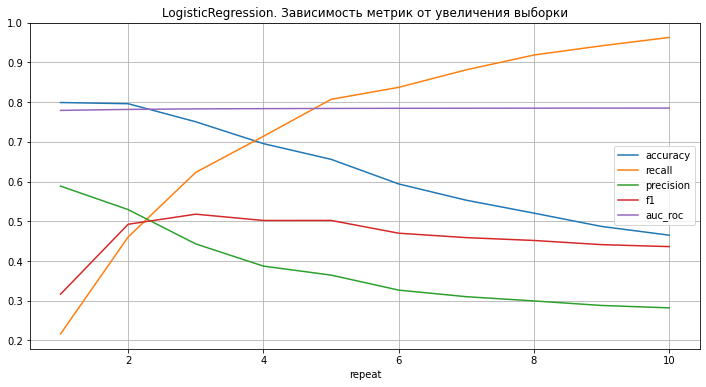

In [65]:
df_scores.plot(x='repeat', y=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], grid=True, figsize=(12,6), title='LogisticRegression. Зависимость метрик от увеличения выборки')

In [66]:
best_param, best_f1_score

(3, 0.5178743961352656)

Лучший результат по метрике f1 (0.52) при трёхкратном увеличении положительного класса. Auc_roc не зависит от изменения выборки. Зависимости точности и полноты меняются x-образно пересекаясь на значении 0.5 при 2-кратном увеличении положительного класса.

#### DecisionTreeClassifier

In [67]:
scores = []
best_f1_score = 0
best_param = 0
for repeat in range(1, 11):
    features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, repeat)
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(features_train_upsampled, target_train_upsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_param = repeat

    scores.append([repeat, accuracy, recall, precision, f1, auc_roc])
    
df_scores = pd.DataFrame(scores, columns=['repeat', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

In [68]:
df_scores

,repeat,accuracy,recall,precision,f1,auc_roc
0,1,0.7900,0.511628,0.511628,0.511628,0.688935
1,2,0.8010,0.506977,0.539604,0.522782,0.694253
2,3,0.7965,0.509302,0.527711,0.518343,0.692231
3,4,0.7955,0.493023,0.526055,0.509004,0.685684
4,5,0.7945,0.486047,0.523810,0.504222,0.682514
5,6,0.7920,0.481395,0.517500,0.498795,0.679233
6,7,0.7945,0.497674,0.523227,0.510131,0.686735
7,8,0.7870,0.483721,0.504854,0.494062,0.676892
8,9,0.7920,0.500000,0.516827,0.508274,0.685987
9,10,0.7945,0.509302,0.522673,0.515901,0.690957


<AxesSubplot:title={'center':'DecisionTreeClassifier. Зависимость метрик от увеличения выборки'}, xlabel='repeat'>

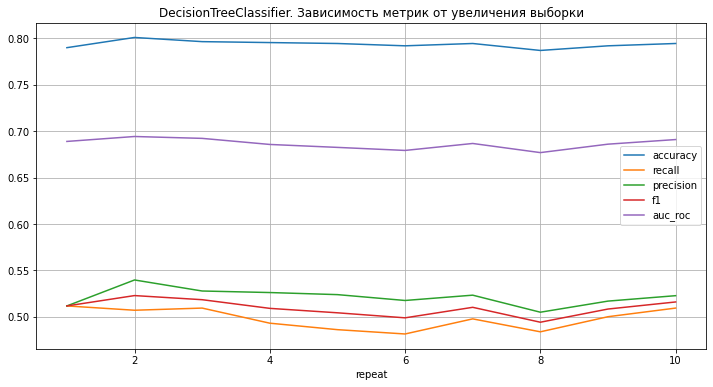

In [69]:
df_scores.plot(x='repeat', y=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], grid=True, figsize=(12,6), title='DecisionTreeClassifier. Зависимость метрик от увеличения выборки')

In [70]:
best_param, best_f1_score

(2, 0.5227817745803358)

In [71]:
best_repeat_decisiontree = best_param

При увеличении выборки метрика f1 уменьшилась. auc_roc коррелирует с f1. Остальные метрики также слабо меняются.

#### RandomForestClassifier

In [72]:
scores = []
best_f1_score = 0
best_param = 0
for repeat in range(1, 11):
    features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, repeat)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(features_train_upsampled, target_train_upsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_param = repeat
        
    scores.append([repeat, accuracy, recall, precision, f1, auc_roc])
    
df_scores = pd.DataFrame(scores, columns=['repeat', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

In [73]:
df_scores

,repeat,accuracy,recall,precision,f1,auc_roc
0,1,0.8580,0.465116,0.787402,0.584795,0.864084
1,2,0.8530,0.532558,0.711180,0.609043,0.863690
2,3,0.8475,0.544186,0.682216,0.605433,0.860436
3,4,0.8515,0.560465,0.690544,0.618742,0.861465
4,5,0.8500,0.560465,0.684659,0.616368,0.858265
5,6,0.8480,0.546512,0.683140,0.607235,0.857724
6,7,0.8455,0.532558,0.679525,0.597132,0.854767
7,8,0.8480,0.553488,0.680000,0.610256,0.858154
8,9,0.8500,0.555814,0.686782,0.614396,0.857878
9,10,0.8435,0.539535,0.668588,0.597169,0.857096


<AxesSubplot:title={'center':'RandomForestClassifier. Зависимость метрик от увеличения выборки'}, xlabel='repeat'>

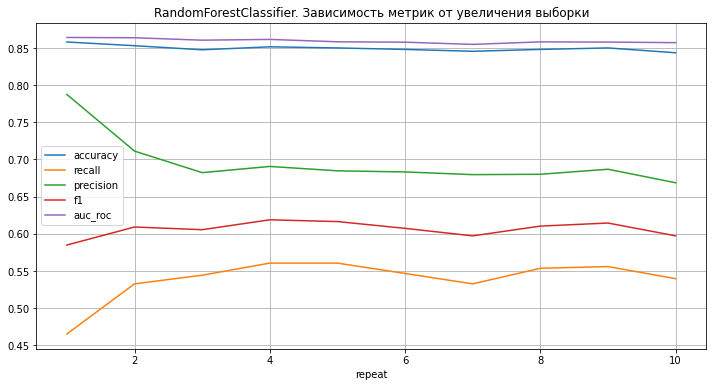

In [74]:
df_scores.plot(x='repeat', y=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], grid=True, figsize=(12,6), title='RandomForestClassifier. Зависимость метрик от увеличения выборки')

In [75]:
best_param, best_f1_score

(4, 0.618741976893453)

In [76]:
best_repeat_randomforest = best_param

Лучший результат по метрике f1 (0.62) при 4x-кратном увеличении положительного класса. auc_roc практически слабо меняется при увеличении выборки, также как и другие метрики.

**Можно отметить, что увеличение положительного класса слабо уменьшило метрики для DecisionTree и слабо увеличило метрики модели RandomForest.**

### Уменьшение выборки

In [77]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

#### LogisticRegression

In [78]:
scores = []
best_f1_score = 0
best_param = 0
for fraction in np.arange(0.9, 0, -0.1):
    features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, fraction)
    
    model = LogisticRegression(random_state=42, solver='liblinear')
    model.fit(features_train_downsampled, target_train_downsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_param = fraction

    scores.append([fraction, accuracy, recall, precision, f1, auc_roc])
    
df_scores = pd.DataFrame(scores, columns=['fraction', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

In [79]:
df_scores

,fraction,accuracy,recall,precision,f1,auc_roc
0,0.9,0.7990,0.255814,0.572917,0.353698,0.780019
1,0.8,0.8005,0.300000,0.568282,0.392694,0.780372
2,0.7,0.8045,0.353488,0.573585,0.437410,0.780872
3,0.6,0.8035,0.416279,0.557632,0.476698,0.781699
4,0.5,0.7955,0.488372,0.526316,0.506634,0.781909
5,0.4,0.7680,0.562791,0.467181,0.510549,0.782108
6,0.3,0.7360,0.672093,0.427515,0.522604,0.782785
7,0.2,0.6490,0.797674,0.358038,0.494236,0.783897
8,0.1,0.4725,0.955814,0.284036,0.437933,0.786125


<AxesSubplot:title={'center':'LogisticRegression. Зависимость метрик от уменьшения выборки'}, xlabel='fraction'>

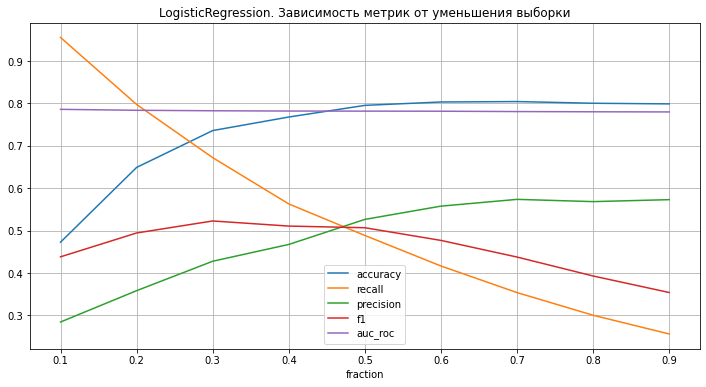

In [80]:
df_scores.plot(x='fraction', y=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], grid=True, figsize=(12,6), title='LogisticRegression. Зависимость метрик от уменьшения выборки')

In [81]:
best_param, best_f1_score

(0.30000000000000016, 0.5226039783001808)

Лучший результат по метрике f1 (0.52) при уменьшении отрицательного класса до 0.3. auc_roc не меняется при уменьшении отрицательного класса

С уменьшением отрицательного класса видно, что полнота растёт (уменьшается доля FN), а точность падает (растёт доля FP), их пересечение х=образно в точке 0.5 происходит при уменьшении отрицательного класса до 0.5.

#### DecisionTreeClassifier

In [82]:
scores = []
best_f1_score = 0
best_param = 0
for fraction in np.arange(0.9, 0, -0.1):
    features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, fraction)
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(features_train_downsampled, target_train_downsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_param = fraction

    scores.append([fraction, accuracy, recall, precision, f1, auc_roc])
    
df_scores = pd.DataFrame(scores, columns=['fraction', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

In [83]:
df_scores

,fraction,accuracy,recall,precision,f1,auc_roc
0,0.9,0.7865,0.534884,0.503282,0.518602,0.695149
1,0.8,0.7910,0.558140,0.512821,0.534521,0.706458
2,0.7,0.7785,0.588372,0.487476,0.533193,0.709473
3,0.6,0.7470,0.576744,0.433566,0.495010,0.685187
4,0.5,0.7505,0.604651,0.441426,0.510304,0.697549
5,0.4,0.7355,0.646512,0.424427,0.512442,0.703192
6,0.3,0.7135,0.723256,0.406536,0.520502,0.717042
7,0.2,0.6590,0.723256,0.355835,0.476994,0.682329
8,0.1,0.5870,0.793023,0.316327,0.452255,0.661798


<AxesSubplot:title={'center':'DecisionTreeClassifier. Зависимость метрик от уменьшения выборки'}, xlabel='fraction'>

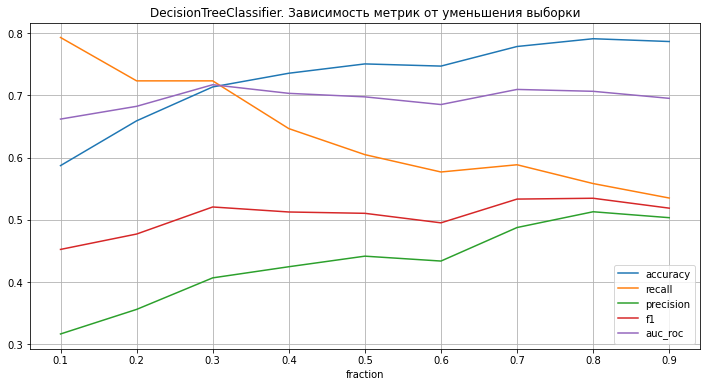

In [84]:
df_scores.plot(x='fraction', y=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], grid=True, figsize=(12,6), title='DecisionTreeClassifier. Зависимость метрик от уменьшения выборки')

In [85]:
best_param, best_f1_score

(0.8, 0.5345211581291759)

In [86]:
best_fraction_decisiontree = best_param

Лучший результат по метрике f1 (0.54) при уменьшении отрицательного класса до 0.8. auc_roc коррелирует с f1

С уменьшением отрицательного класса также видно, что от общего значения около 0.5 полнота растёт (уменьшается доля FN), а точность при этом падает (растёт доля FP).

#### RandomForestClassifier

In [87]:
scores = []
best_f1_score = 0
best_param = 0
for fraction in np.arange(0.9, 0, -0.1):
    features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, fraction)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(features_train_downsampled, target_train_downsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_param = fraction

    scores.append([fraction, accuracy, recall, precision, f1, auc_roc])
    
df_scores = pd.DataFrame(scores, columns=['fraction', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

In [88]:
df_scores

,fraction,accuracy,recall,precision,f1,auc_roc
0,0.9,0.8595,0.493023,0.770909,0.601418,0.860430
1,0.8,0.8595,0.525581,0.745875,0.616644,0.863275
2,0.7,0.8540,0.551163,0.705357,0.618799,0.867509
3,0.6,0.8565,0.588372,0.696970,0.638083,0.862549
4,0.5,0.8405,0.625581,0.629977,0.627771,0.864919
5,0.4,0.8370,0.697674,0.604839,0.647948,0.865416
6,0.3,0.8110,0.755814,0.543478,0.632296,0.861549
7,0.2,0.7535,0.806977,0.458388,0.584667,0.855581
8,0.1,0.6045,0.911628,0.342358,0.497778,0.841029


<AxesSubplot:title={'center':'RandomForestClassifier. Зависимость метрик от уменьшения выборки'}, xlabel='fraction'>

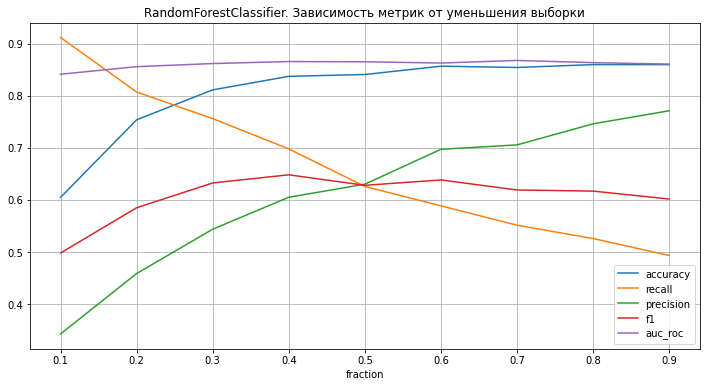

In [89]:
df_scores.plot(x='fraction', y=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], grid=True, figsize=(12,6), title='RandomForestClassifier. Зависимость метрик от уменьшения выборки')

In [90]:
best_param, best_f1_score

(0.40000000000000013, 0.6479481641468682)

In [91]:
best_fraction_randomforest = best_param

Лучший результат по метрике f1 (0.64) при уменьшении отрицательного класса до 0.5. auc_roc слабо коррелирует с f1

### Изменение порога

Рассмотрим модель линейной регрессии, и рассчитаем оценки для разного порога предсказания класса.

In [92]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [93]:
pd.DataFrame([get_model_scores(model, features_valid, target_valid)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.799,0.216279,0.588608,0.316327,0.779153


In [94]:
threshold_scores = []
for threshold in np.arange(0, 0.4, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    
    accuracy = accuracy_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    precision = precision_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    threshold_scores.append([threshold, accuracy, recall, precision, f1, auc_roc])
    
df_scores = pd.DataFrame(threshold_scores, columns=['threshold', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

In [95]:
df_scores

,threshold,accuracy,recall,precision,f1,auc_roc
0,0.00,0.2150,1.000000,0.215000,0.353909,0.779153
1,0.02,0.2205,1.000000,0.216189,0.355519,0.779153
2,0.04,0.2665,1.000000,0.226674,0.369575,0.779153
3,0.06,0.3430,0.986047,0.244804,0.392229,0.779153
4,0.08,0.4190,0.969767,0.266284,0.417836,0.779153
5,0.10,0.4785,0.932558,0.283392,0.434688,0.779153
6,0.12,0.5260,0.886047,0.297656,0.445614,0.779153
7,0.14,0.5710,0.846512,0.314879,0.459016,0.779153
8,0.16,0.6240,0.813953,0.342466,0.482094,0.779153
9,0.18,0.6655,0.767442,0.367075,0.496614,0.779153


<AxesSubplot:title={'center':'RandomForestClassifier. Зависимость метрик от уменьшения выборки'}, xlabel='threshold'>

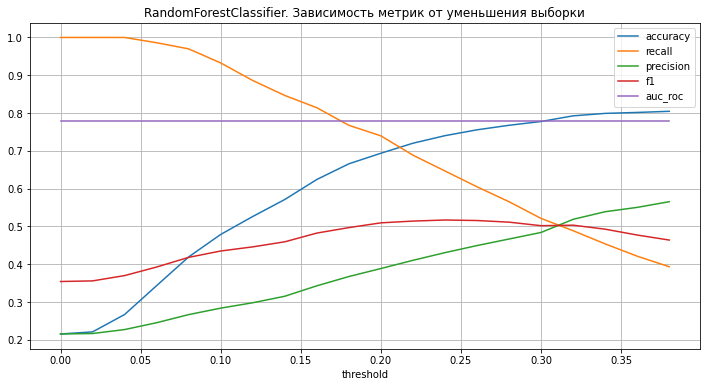

In [96]:
df_scores.plot(x='threshold', y=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], grid=True, figsize=(12,6), title='RandomForestClassifier. Зависимость метрик от уменьшения выборки')

Наилучший вариант оказался при пороге 0.24: f1 = 0.52, хотя и доля правильных ответов ко всем правильным (precision) невелика.

Оценка auc_roc не зависит от порога.

**Вывод**

учший результат по метрике f1 (0.64) для модели **RandomForestClassifier** при уменьшении отрицательного класса до 0.5.

Метрика auc_roc меняется и коррелирует с f1 только для модели DecisionTreeClassifier, в остальных случаях остаётся постоянной при балансировкие классов

### Получим наилучшую модель

Не будем рассматривать LogisticRegression, т. к. она показала самые низкие метрики.

#### DecisionTreeClassifier

Лучшие результаты были получены при уменьшении выборки. Будем базироваться на этой основе.

In [97]:
scores = []
best_f1_score = 0
best_hyperparam = 0

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, best_fraction_decisiontree)

for depth in tqdm(range(1, 16, 1)):
    model = DecisionTreeClassifier(random_state=42, min_samples_split=2, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_hyperparam = depth
    scores.append([depth, accuracy, recall, precision, f1, auc_roc])
    
pd.DataFrame(scores, columns=['depth', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

  0%|          | 0/15 [00:00<?, ?it/s]

,depth,accuracy,recall,precision,f1,auc_roc
0,1,0.7760,0.537209,0.481250,0.507692,0.689305
1,2,0.8395,0.409302,0.724280,0.523031,0.741792
2,3,0.8440,0.434884,0.730469,0.545190,0.797571
3,4,0.8510,0.383721,0.833333,0.525478,0.821949
4,5,0.8555,0.579070,0.697479,0.632783,0.843500
5,6,0.8585,0.504651,0.756098,0.605300,0.844670
6,7,0.8575,0.539535,0.727273,0.619493,0.839278
7,8,0.8465,0.548837,0.676218,0.605905,0.814832
8,9,0.8440,0.525581,0.676647,0.591623,0.802701
9,10,0.8405,0.534884,0.659026,0.590501,0.769752


In [98]:
best_f1_score, best_hyperparam

(0.6327827191867852, 5)

In [99]:
max_depth = best_hyperparam

In [100]:
scores = []
best_f1_score = 0
best_hyperparam = 0
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, best_fraction_decisiontree)

for samples_leaf in tqdm(range(1, 26, 1)):
    model = DecisionTreeClassifier(random_state=42, min_samples_leaf=samples_leaf, max_depth=max_depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_hyperparam = samples_leaf
    scores.append([samples_leaf, accuracy, recall, precision, f1, auc_roc])
    
pd.DataFrame(scores, columns=['samples_leaf', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

  0%|          | 0/25 [00:00<?, ?it/s]

,samples_leaf,accuracy,recall,precision,f1,auc_roc
0,1,0.8555,0.579070,0.697479,0.632783,0.843500
1,2,0.8545,0.574419,0.695775,0.629299,0.842646
2,3,0.8530,0.572093,0.691011,0.625954,0.842110
3,4,0.8520,0.567442,0.689266,0.622449,0.841799
4,5,0.8545,0.579070,0.693593,0.631179,0.842394
5,6,0.8545,0.579070,0.693593,0.631179,0.842420
6,7,0.8545,0.579070,0.693593,0.631179,0.842706
7,8,0.8545,0.579070,0.693593,0.631179,0.842483
8,9,0.8545,0.579070,0.693593,0.631179,0.842863
9,10,0.8545,0.579070,0.693593,0.631179,0.842831


In [101]:
best_f1_score, best_hyperparam

(0.6327827191867852, 1)

min_samples_leaf = 17

#### RandomForestClassifier

Лучшие результаты были получены при уменьшении выборки. Учтём это.

In [102]:
scores = []
best_f1_score = 0
best_hyperparam = 0

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, best_fraction_randomforest)

for depth in tqdm(range(1, 16, 1)):
    model = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_hyperparam = depth
    scores.append([depth, accuracy, recall, precision, f1, auc_roc])
    
pd.DataFrame(scores, columns=['depth', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

  0%|          | 0/15 [00:00<?, ?it/s]

,depth,accuracy,recall,precision,f1,auc_roc
0,1,0.8070,0.116279,0.892857,0.205761,0.742200
1,2,0.8335,0.306977,0.790419,0.442211,0.830384
2,3,0.8510,0.525581,0.706250,0.602667,0.842002
3,4,0.8410,0.565116,0.649733,0.604478,0.844784
4,5,0.8455,0.620930,0.646489,0.633452,0.857182
5,6,0.8430,0.648837,0.631222,0.639908,0.859013
6,7,0.8375,0.639535,0.617978,0.628571,0.859071
7,8,0.8305,0.641860,0.598698,0.619529,0.857356
8,9,0.8360,0.681395,0.605372,0.641138,0.859165
9,10,0.8300,0.658140,0.594538,0.624724,0.851943


In [103]:
best_f1_score, best_hyperparam

(0.6418400876232201, 12)

In [104]:
best_max_depth_randomforest = best_hyperparam

In [105]:
scores = []
best_f1_score = 0
best_hyperparam = 0
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, best_fraction_randomforest)

for n_estimators in tqdm(range(20, 350, 10)):
    model = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=best_max_depth_randomforest)
    model.fit(features_train_downsampled, target_train_downsampled)
    accuracy, recall, precision, f1, auc_roc = get_model_scores(model, features_valid, target_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_hyperparam = n_estimators
    scores.append([n_estimators, accuracy, recall, precision, f1, auc_roc])
    
pd.DataFrame(scores, columns=['n_estimators', 'accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

  0%|          | 0/33 [00:00<?, ?it/s]

,n_estimators,accuracy,recall,precision,f1,auc_roc
0,20,0.8365,0.681395,0.606625,0.641840,0.858405
1,30,0.8365,0.679070,0.607069,0.641054,0.863456
2,40,0.8385,0.690698,0.609856,0.647764,0.865940
3,50,0.8425,0.695349,0.619048,0.654984,0.868015
4,60,0.8440,0.700000,0.621901,0.658643,0.868436
5,70,0.8385,0.695349,0.608961,0.649294,0.868393
6,80,0.8365,0.688372,0.605317,0.644178,0.867738
7,90,0.8365,0.688372,0.605317,0.644178,0.868058
8,100,0.8370,0.688372,0.606557,0.644880,0.868840
9,110,0.8405,0.686047,0.615866,0.649065,0.868962


In [106]:
best_f1_score, best_hyperparam

(0.6593647316538883, 310)

In [107]:
best_n_estimators_randomforest = best_hyperparam

Из двух моделей лучший результат f1 (0.65) показала **RandomForestClassifier с гиперпараметрами n_estimators=20, max_depth=12 при двукратном увеличении положительного класса**

## Тестирование модели

In [108]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, best_fraction_randomforest)
model = RandomForestClassifier(random_state=42, n_estimators=best_n_estimators_randomforest, max_depth=best_max_depth_randomforest)
model.fit(features_train_downsampled, target_train_downsampled)

RandomForestClassifier(max_depth=12, n_estimators=310, random_state=42)

In [109]:
features_test[numeric] = scaler.transform(features_test[numeric])
pd.DataFrame([get_model_scores(model, features_test, target_test)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])


,accuracy,recall,precision,f1,auc_roc
0,0.8285,0.626316,0.542141,0.581197,0.840507


Для тестовой выборки f1 и auc_roc оказались чуть меньше: 0.57 и 0.83 (против 0.65 и 0.87 на валидационной)

### Дообучение

Объединим тренировочную и валидационную выборки и снова обучим модель.

In [110]:
features_final = pd.concat([features_train] + [features_valid])

In [111]:
target_final = pd.concat([target_train] + [target_valid])

In [112]:
features_final.shape

(8000, 11)

In [113]:
target_final.shape

(8000,)

In [114]:
scaler = StandardScaler()
scaler.fit(features_final[numeric])
features_final[numeric] = scaler.transform(features_final[numeric])

In [115]:
features_final_downsampled, target_final_downsampled = downsample(features_final, target_final, best_fraction_randomforest)
model = RandomForestClassifier(random_state=42, n_estimators=best_n_estimators_randomforest, max_depth=best_max_depth_randomforest)
model.fit(features_final_downsampled, target_final_downsampled)

RandomForestClassifier(max_depth=12, n_estimators=310, random_state=42)

In [116]:
features_test[numeric] = scaler.transform(features_test[numeric])
pd.DataFrame([get_model_scores(model, features_test, target_test)],
             columns=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'])

,accuracy,recall,precision,f1,auc_roc
0,0.826,0.623684,0.536199,0.576642,0.843341


Дообученная модель вплотную приблизила метрику f1 к 0.59

In [117]:
features_test.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [118]:
model.feature_importances_

array([0.10589538, 0.29140133, 0.06279479, 0.12271245, 0.16967036,
       0.01471877, 0.05465876, 0.10571238, 0.0379949 , 0.01200928,
       0.02243159])

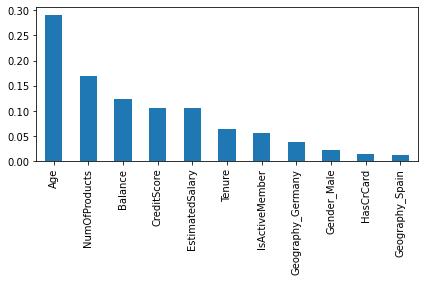

In [119]:
import matplotlib.pyplot as plt
feature_names = features_test.columns
model_importances = pd.Series(model.feature_importances_, index=feature_names)
model_importances = model_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
model_importances.plot.bar(ax=ax)
fig.tight_layout()

Наибольший вклад в моделях внесли возраст, количество используемых продустов банка и баланс на счету, меньше всего пол, наличие карты и продолжительность пользования услугами